<a href="https://colab.research.google.com/github/suyashss/nn_test/blob/master/neural_style_transfer_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
import tensorflow.keras as keras

## Load VGG model and extract convolutional layers

In [ ]:
vgg = keras.applications.VGG19(include_top=True,weights='imagenet')

574717952/574710816 [==============================] - 7s 0us/step


In [ ]:
select_layer_names = ['block{}_conv1'.format(x) for x in range(1,6)]
print(select_layer_names)

['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


# Get image and view

In [ ]:
!wget --quiet https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [ ]:
content_path = '1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

## Define utility functions for image processing and viewing

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = keras.preprocessing.image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [ ]:
def preprocess_img(path_to_img):
  img = load_img(path_to_img)
  out = keras.applications.vgg19.preprocess_input(img)
  return out

In [ ]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

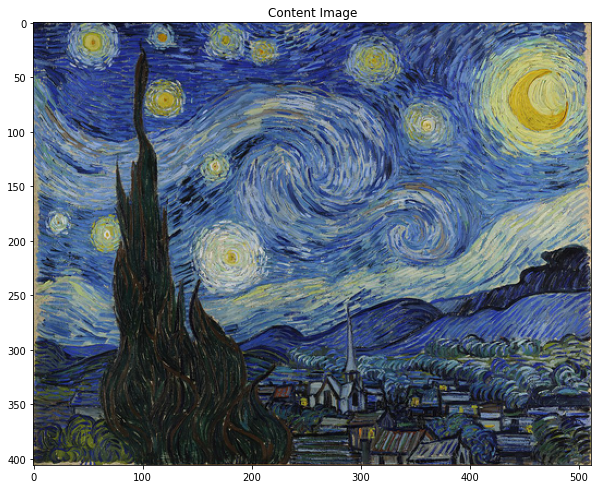

In [ ]:
content = load_img(content_path).astype('uint8')
#style = load_img(style_path).astype('uint8')

#plt.subplot(1, 1, 1)
imshow(content, 'Content Image')

#plt.subplot(1, 2, 2)
#imshow(style, 'Style Image')
plt.show()


## Define model to get outputs of selected convolutional layers

In [ ]:
intermediate_layer_model = keras.Model(inputs=vgg.input,
                                       outputs=[vgg.get_layer(layer_name).output for layer_name in select_layer_names])

In [ ]:
content_vgg_in = preprocess_img(content_path)

In [ ]:
intermediate_outputs = intermediate_layer_model(content_vgg_in)

In [ ]:
for x in intermediate_outputs:
  print(x.shape)

(1, 406, 512, 64)
(1, 203, 256, 128)
(1, 101, 128, 256)
(1, 50, 64, 512)
(1, 25, 32, 512)


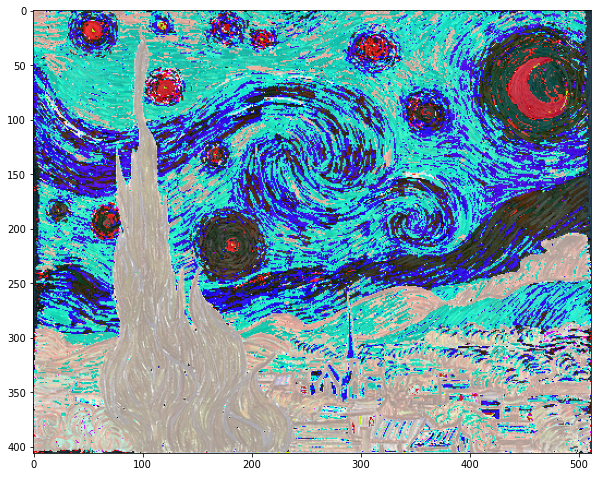

In [ ]:
imshow(content_vgg_in)

In [ ]:
temp = deprocess_img(content_vgg_in)
print(temp.shape)

(406, 512, 3)


In [ ]:
content_vgg_in.shape

(1, 406, 512, 3)

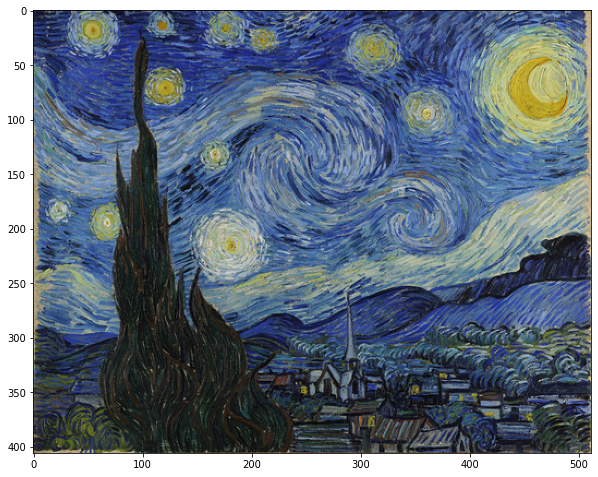

In [ ]:
imshow([temp])

# Content reconstruction experiments

In [ ]:
def content_loss(img1_feat,img2,model,layer_idx): # Features for a specific layer 
  return tf.reduce_mean(tf.square(img1_feat - model(img2)[layer_idx]))  

In [ ]:
def content_grads(img1_feat,init_image,model,layer_idx):
  with tf.GradientTape() as tape: 
    #tape.watch(init_image)
    all_loss = content_loss(img1_feat,init_image,model,layer_idx)
  # Compute gradients wrt input image
  return tape.gradient(all_loss, init_image), all_loss

In [ ]:
opt = tf.optimizers.Adam(learning_rate=15,)

In [ ]:
def run_content_reconstruction_loop(content_vgg_in,opt,layer_idx):
  init_image = tf.Variable(tf.random.uniform(content_vgg_in.shape,minval=0,maxval=255,dtype='float32'))
  target_out = intermediate_layer_model(content_vgg_in)
  num_iterations = 100
  loss_seq = []
  image_seq = [init_image]
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means 
  for i in range(num_iterations):
    image_out = intermediate_layer_model(init_image)
    grads, curr_loss = content_grads(target_out[layer_idx],init_image,intermediate_layer_model,layer_idx)
    loss_seq.append(curr_loss)
    if i % 10 ==0:
      print("Iteration = {}, loss = {}".format(i,curr_loss))
      image_seq.append(init_image)
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
  return image_seq,loss_seq   

## Test reconstruction at layer 0

Iteration = 0, loss = 6677.42724609375
Iteration = 10, loss = 934.7847290039062
Iteration = 20, loss = 145.36691284179688
Iteration = 30, loss = 89.5168685913086
Iteration = 40, loss = 30.591909408569336
Iteration = 50, loss = 10.287803649902344
Iteration = 60, loss = 5.635479927062988
Iteration = 70, loss = 2.0352141857147217
Iteration = 80, loss = 1.3307240009307861
Iteration = 90, loss = 0.7538073062896729


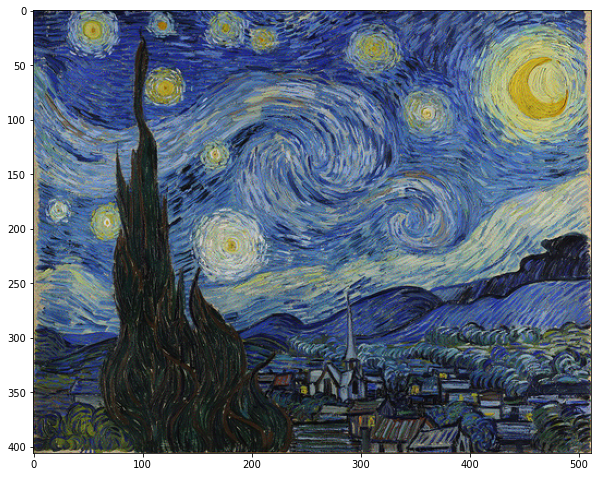

In [ ]:
im_seq,loss_seq = run_content_reconstruction_loop(content_vgg_in,opt,0)
plt.imshow(deprocess_img(im_seq[-1].numpy()))

## Test reconstruction at layer 4

Iteration = 0, loss = 15773.947265625
Iteration = 10, loss = 4668.7783203125
Iteration = 20, loss = 2697.30810546875
Iteration = 30, loss = 1853.2208251953125
Iteration = 40, loss = 1333.26318359375
Iteration = 50, loss = 1027.2930908203125
Iteration = 60, loss = 830.1882934570312
Iteration = 70, loss = 634.2679443359375
Iteration = 80, loss = 512.6889038085938
Iteration = 90, loss = 450.57147216796875


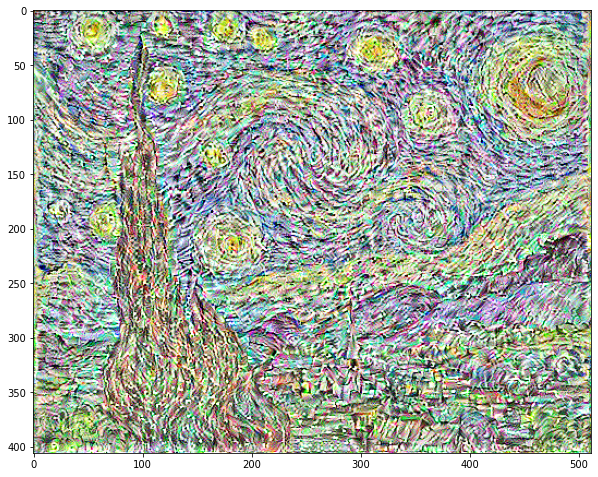

In [ ]:
im_seq,loss_seq = run_content_reconstruction_loop(content_vgg_in,opt,4)
plt.imshow(deprocess_img(im_seq[-1].numpy()))

# Style reconstruction experiments

In [ ]:
def compute_gram(img_feat):
  img_shape = img_feat.shape
  img_vec = tf.reshape(img_feat,[-1,img_shape[-1]])
  n = tf.cast(img_vec.shape[0]*img_vec.shape[1],'float32')
  g = tf.matmul(a=img_vec,b=img_vec,transpose_a=True)/n
  return g

In [ ]:
def style_loss(img1_gram,img2,model,layer_idx): # Features for a specific layer 
  img2_feat = model(img2)
  img2_gram = [compute_gram(x) for x in img2_feat[0:layer_idx]]
  return tf.reduce_mean(tf.convert_to_tensor([tf.reduce_mean(tf.square(x-y)) for x,y in zip(img1_gram,img2_gram)]))
#  return tf.reduce_mean(tf.square(tf.convert_to_tensor(img1_gram[:layer_idx]) - tf.convert_to_tensor(img2_gram[:layer_idx])))  

In [ ]:
def style_grads(img1_gram,init_image,model,layer_idx):
  with tf.GradientTape() as tape: 
    all_loss = style_loss(img1_gram,init_image,model,layer_idx)
  # Compute gradients wrt input image
  return tape.gradient(all_loss, init_image), all_loss

In [ ]:
def run_style_reconstruction_loop(content_vgg_in,opt,layer_idx):
  init_image = tf.Variable(tf.random.uniform(content_vgg_in.shape,minval=0,maxval=255,dtype='float32'))
  target_out = intermediate_layer_model(content_vgg_in)
  target_gram = [compute_gram(x) for x in target_out[0:layer_idx]]  
  num_iterations = 1000
  loss_seq = []
  image_seq = [init_image]
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  for i in range(num_iterations):
    image_out = intermediate_layer_model(init_image)
    grads, curr_loss = style_grads(target_gram,init_image,intermediate_layer_model,layer_idx)
    loss_seq.append(curr_loss)
    if i % 50 ==0:
      print("Iteration = {}, loss = {}".format(i,curr_loss))
      image_seq.append(init_image)
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    if curr_loss < 0.01:
      break
  return image_seq,loss_seq   

## Test reconstruction at layer 0

Iteration = 0, loss = 4729.8291015625
Iteration = 50, loss = 4.582450866699219
Iteration = 100, loss = 0.5105866193771362
Iteration = 150, loss = 0.21883118152618408
Iteration = 200, loss = 0.10566379129886627
Iteration = 250, loss = 0.057194098830223083
Iteration = 300, loss = 0.034142784774303436
Iteration = 350, loss = 0.021885287016630173
Iteration = 400, loss = 0.014868716709315777
Iteration = 450, loss = 0.010623479261994362


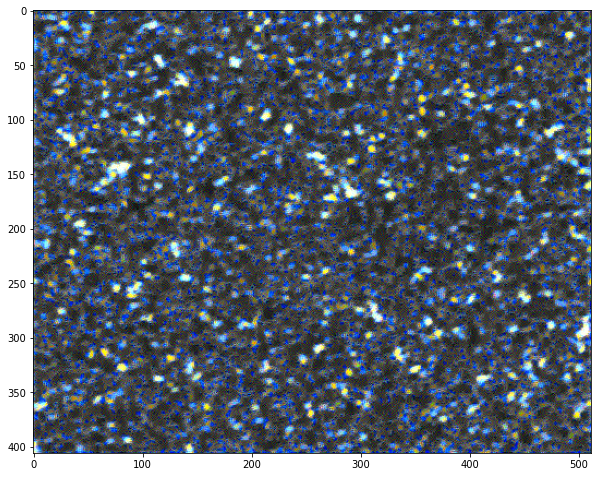

In [ ]:
im_seq,loss_seq = run_style_reconstruction_loop(content_vgg_in,opt,1)
plt.imshow(deprocess_img(im_seq[-1].numpy()))

## Test reconstruction at layers 0 through 4

Iteration = 0, loss = 1510701.375
Iteration = 50, loss = 2956.263427734375
Iteration = 100, loss = 971.3402099609375
Iteration = 150, loss = 606.8115844726562
Iteration = 200, loss = 446.1171875
Iteration = 250, loss = 356.0499267578125
Iteration = 300, loss = 298.95989990234375
Iteration = 350, loss = 259.55194091796875
Iteration = 400, loss = 230.71609497070312
Iteration = 450, loss = 208.4851837158203
Iteration = 500, loss = 190.67955017089844
Iteration = 550, loss = 175.90780639648438
Iteration = 600, loss = 163.30914306640625
Iteration = 650, loss = 152.3715057373047
Iteration = 700, loss = 142.7288818359375
Iteration = 750, loss = 134.11410522460938
Iteration = 800, loss = 126.37318420410156
Iteration = 850, loss = 119.36412048339844
Iteration = 900, loss = 112.98518371582031
Iteration = 950, loss = 107.14820861816406


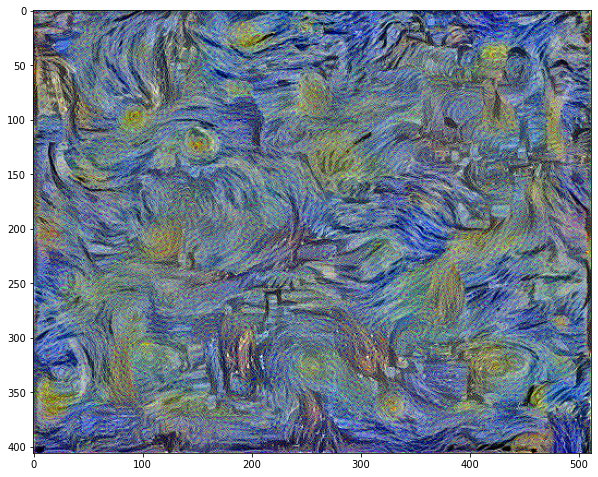

In [ ]:
im_seq,loss_seq = run_style_reconstruction_loop(content_vgg_in,opt,5)
plt.imshow(deprocess_img(im_seq[-1].numpy()))

# Style transfer

In [ ]:
!wget --quiet https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg

In [ ]:
style_path = '1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'
content_path = 'Tuebingen_Neckarfront.jpg'

In [ ]:
style_vgg_in = preprocess_img(style_path)
content_vgg_in = preprocess_img(content_path)

In [ ]:
def content_style_loss(content_out,style_gram,init_image,intermediate_layer_model,content_layer_idx,style_layer_idx,style_content_ratio):
  img_feat = intermediate_layer_model(init_image)
  img_gram = [compute_gram(x) for x in img_feat]
  content_loss = tf.reduce_mean(tf.square(content_out[content_layer_idx] - img_feat[content_layer_idx])) 
  style_loss = tf.reduce_mean(tf.convert_to_tensor([tf.reduce_mean(tf.square(x-y)) for x,y in zip(img_gram[0:style_layer_idx],style_gram[0:style_layer_idx])]))
  return content_loss + style_content_ratio * style_loss

In [ ]:
def content_style_grads(content_out,style_gram,init_image,intermediate_layer_model,content_layer_idx,style_layer_idx,style_content_ratio):
  with tf.GradientTape() as tape: 
    all_loss = content_style_loss(content_out,style_gram,init_image,intermediate_layer_model,content_layer_idx,style_layer_idx,style_content_ratio)
  # Compute gradients wrt input image
  return tape.gradient(all_loss, init_image), all_loss

In [ ]:
def run_style_transfer_loop(content_vgg_in,style_vgg_in,opt,intermediate_layer_model,content_layer_idx,style_layer_idx,style_content_ratio):
  init_image = tf.Variable(tf.random.uniform(content_vgg_in.shape,minval=0,maxval=255,dtype='float32'))
  content_out = intermediate_layer_model(content_vgg_in)
  style_out = intermediate_layer_model(style_vgg_in)
  style_gram = [compute_gram(x) for x in style_out]  
  num_iterations = 1000
  loss_seq = []
  image_seq = [init_image]
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  for i in range(num_iterations):
    grads, curr_loss = content_style_grads(content_out,style_gram,init_image,intermediate_layer_model,content_layer_idx,style_layer_idx,style_content_ratio)
    loss_seq.append(curr_loss)
    if i % 50 ==0:
      print("Iteration = {}, loss = {}".format(i,curr_loss))
      image_seq.append(init_image)
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    if curr_loss < 0.01:
      break
  if len(image_seq) < 2:
    image_seq.append(init_image)
    loss_seq.apppend(curr_loss)    
  return image_seq[-1],loss_seq[-1]   

In [ ]:
layer_idxes = [1,2,3,4]
ratio_vals = [np.power(10.0,x) for x in range(-3,3)]

In [ ]:
opt = tf.optimizers.Adam(learning_rate=15,)
out_dict = dict()
for idx in layer_idxes:
  for val in ratio_vals:
    print("Idx={}, Ratio={}".format(idx,val))
    im_seq,loss_seq = run_style_transfer_loop(content_vgg_in,style_vgg_in,opt,intermediate_layer_model,idx,idx,val)
    out_dict[(idx,val)] = im_seq

Idx=1, Ratio=0.001
Iteration = 0, loss = 109808.421875
Iteration = 50, loss = 1969.3623046875
Iteration = 100, loss = 922.202392578125
Iteration = 150, loss = 546.838134765625
Iteration = 200, loss = 272.7055969238281
Iteration = 250, loss = 50.54792404174805
Iteration = 300, loss = 15.45663833618164
Iteration = 350, loss = 14.520159721374512
Iteration = 400, loss = 15.337450981140137
Iteration = 450, loss = 18.956279754638672
Iteration = 500, loss = 29.99713897705078
Iteration = 550, loss = 28.30898666381836
Iteration = 600, loss = 34.07379150390625
Iteration = 650, loss = 152.59564208984375
Iteration = 700, loss = 213.39654541015625
Iteration = 750, loss = 51.675960540771484
Iteration = 800, loss = 25.01886749267578
Iteration = 850, loss = 38.69956588745117
Iteration = 900, loss = 44.8167839050293
Iteration = 950, loss = 34.456546783447266
Idx=1, Ratio=0.01
Iteration = 0, loss = 109560.046875
Iteration = 50, loss = 374.0656433105469
Iteration = 100, loss = 20.0394229888916
Iteration 

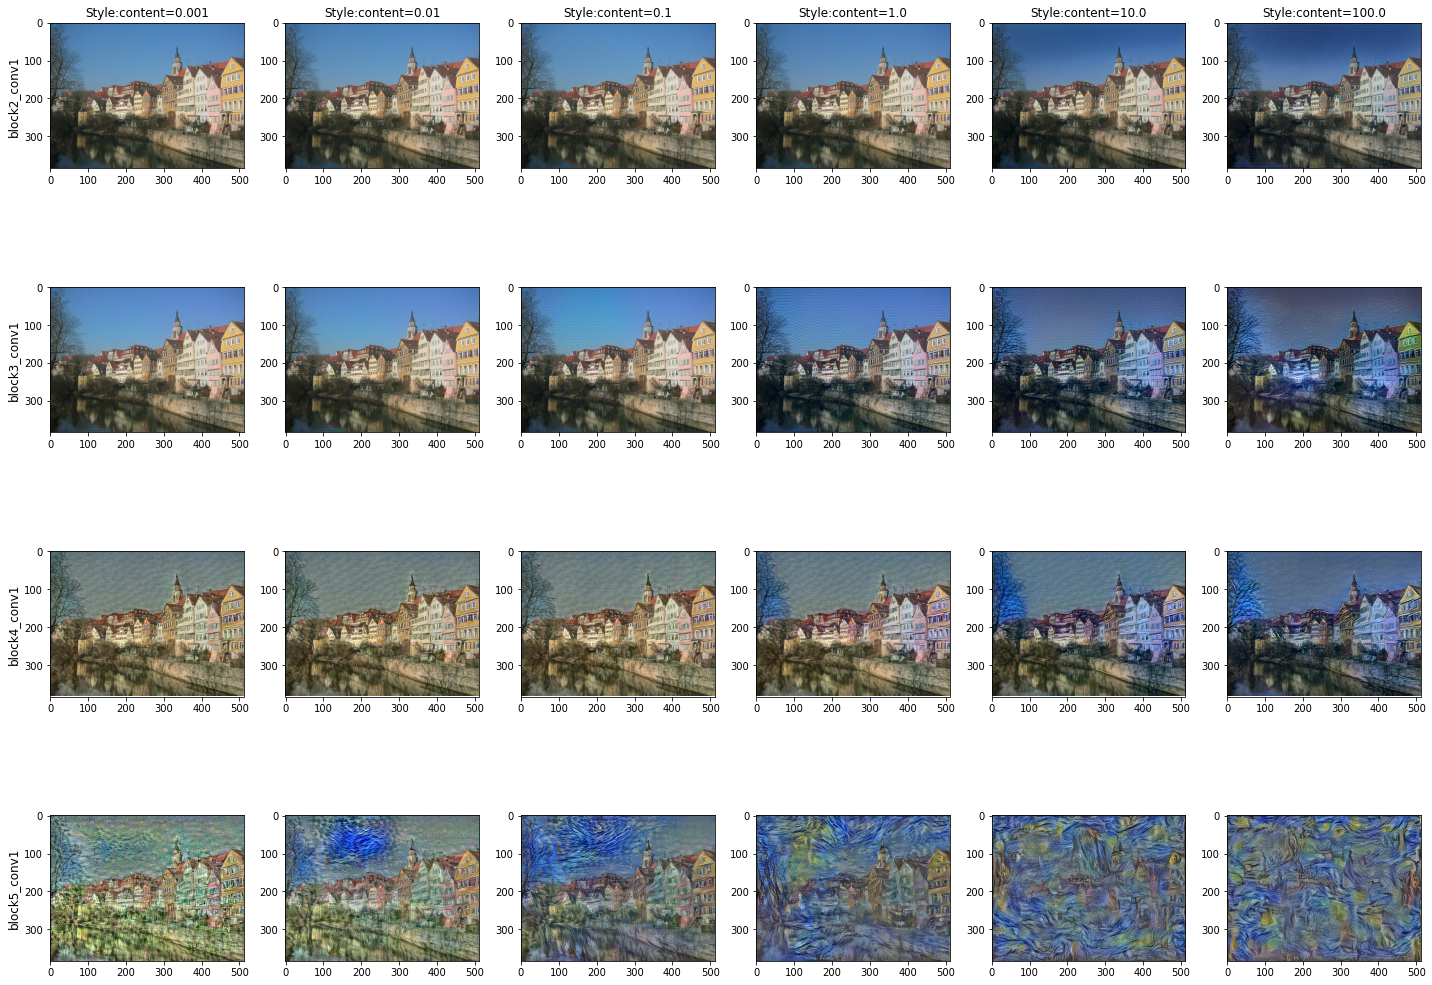

In [ ]:
nindices = len(layer_idxes)
nvals = len(ratio_vals)
num_plots = nindices*nvals
#mpl.rcParams['figure.figsize'] = (20,20)
#mpl.rcParams['axes.grid'] = False
fig, axes = plt.subplots(nrows=nindices, ncols=nvals, figsize=(20, 15))
for ax, col in zip(axes[0], ratio_vals):
    ax.set_title("Style:content={}".format(col))

for ax, row in zip(axes[:,0], layer_idxes):
    ax.set_ylabel(select_layer_names[row], rotation=90, size='large')

fig.tight_layout()
for i,idx in enumerate(layer_idxes):
  for j,val in enumerate(ratio_vals):
    #plt.subplot(nindices, nvals,i*nvals+j+1)
    #plt.imshow(deprocess_img(out_dict[(idx,val)].numpy()))
    axes[i,j].imshow(deprocess_img(out_dict[(idx,val)].numpy()))

